# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### Check the c_AMP richness of species through different environments

We generate sets of c_AMPs by species and sample. Then group them by environment and select those species happening in at least 2 habitats with at least 10 samples in each. The number of non-redundant c_AMPs attributed to a given species per sample in each sample is compared using Mann-Whitney U test and later the p-values are adjusted using Holm-Sidak.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations, chain
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests as mt

In [2]:
# load data
data = pd.read_table('data/complete_amps_associated_taxonomy.tsv.gz')
metadata = pd.read_table("data/reduced_metadata.tsv.xz")
metadata = metadata.rename({'sample_accession': 'sample'}, axis=1)

In [3]:
# filter and add metadata info
data = data[data.level == 'species']

In [4]:
# clear duplicates and count nr_AMPs per species per habitat
amp_rich = data[['source', 'sample', 'amp']]
amp_rich = amp_rich.drop_duplicates()
amp_rich = amp_rich.groupby(['source', 'sample'])
amp_rich = amp_rich.agg('size')
amp_rich = amp_rich.reset_index()
amp_rich = amp_rich.merge(on='sample', right=metadata)
amp_rich = amp_rich.rename({0: 'nr_amp'}, axis=1)

In [5]:
# fix habitat name
amp_rich.general_envo_name = amp_rich.general_envo_name.replace('human saliva', 'human mouth')

# select species present in >=10 samples per habitats
k = amp_rich.groupby(['source', 'general_envo_name']).agg('size')
k = k[k >= 10]

# select species present in more than 1 habitat
k = k.reset_index().groupby('source').apply(lambda x: x.general_envo_name.tolist())
k = k[k.apply(lambda x: len(x)) > 1]
k = k.reset_index()

In [6]:
# test difference in the nr_AMPs among samples of
# the same species through different environments
test = []
for _, s, env in k.itertuples():
    combs = combinations(env, 2)
    for i, j in combs:
        n1 = amp_rich[(amp_rich.source == s) & (amp_rich.general_envo_name == i)]
        n2 = amp_rich[(amp_rich.source == s) & (amp_rich.general_envo_name == j)]
        u, p = mannwhitneyu(n1['nr_amp'], n2['nr_amp'])
        test.append((s, i, len(n1),
                     n1.nr_amp.mean(), n1.nr_amp.std(),
                     j, len(n2), n2.nr_amp.mean(),
                     n2.nr_amp.std(), p))

In [7]:
# format results
test = pd.DataFrame(test, columns=['species',
                                   'env1',
                                   'n1_samples',
                                   'amp1_avg',
                                   'amp1_std',
                                   'env2',
                                   'n2_samples',
                                   'amp2_avg',
                                   'amp2_std',
                                   'p_value'])

test

,species,env1,n1_samples,amp1_avg,amp1_std,env2,n2_samples,amp2_avg,amp2_std,p_value
0,0-14-0-80-60-11 sp002779455,groundwater,29,1.620690,0.676852,marine,28,2.142857,1.238706,0.172310
1,0-14-0-80-60-11 sp002779455,groundwater,29,1.620690,0.676852,soil,163,1.938650,1.468573,0.739168
2,0-14-0-80-60-11 sp002779455,groundwater,29,1.620690,0.676852,water associated,52,4.826923,4.865731,0.003186
3,0-14-0-80-60-11 sp002779455,marine,28,2.142857,1.238706,soil,163,1.938650,1.468573,0.189473
4,0-14-0-80-60-11 sp002779455,marine,28,2.142857,1.238706,water associated,52,4.826923,4.865731,0.068861
...,...,...,...,...,...,...,...,...,...,...
11233,Zag111 sp004558955,human gut,55,1.000000,0.000000,primate gut,16,1.000000,0.000000,1.000000
11234,Zag111 sp004558955,pig gut,159,1.125786,0.417074,primate gut,16,1.000000,0.000000,0.186412
11235,Zavarzinella formosa,plant associated,16,1.250000,0.577350,soil,140,1.364286,0.824191,0.659402
11236,Zoogloea ramigera,activated sludge,127,1.795276,1.293074,wastewater,191,2.476440,1.905179,0.000221


In [8]:
# adjust p-values
_, test['p_adj'], _, _ = mt(test['p_value'], method='hs')

/home/celio/miniconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [9]:
# export
test.to_csv('species_amp_richness_crossenvironment.tsv.gz', sep='\t', header=True, index=None)

### Generating statistics

In [10]:
n1 = len(set(test.species))
print(f'It was tested {n1} species')

n2 = len(set(test.loc[test.p_adj < 0.05, 'species']))
print(f'''Only {round((n2*100/n1), 2)}% ({n2}) of them
presented significant differences in their AMP richness
across different environments''')

savg = (test.amp1_avg.sum() + test.amp2_avg.sum()) / (2*len(test))

mmax, mmin = [max(test.amp1_avg.max(), test.amp2_avg.max()),
              min(test.amp1_avg.min(), test.amp2_avg.min())]

print(f'''In average, it was observed {savg:.2} AMPs for each species
per sample, ranging between {mmax:.4}-{mmin:.2}.''')

x = len(set(test[(test.amp1_std == 0) | (test.amp2_std == 0)].species))
print(f'{x} species presented a constant number of non-redundant c_AMPs in samples from at least 1 environment')

It was tested 4305 species
Only 7.25% (312) of them
presented significant differences in their AMP richness
across different environments
In average, it was observed 1.4 AMPs for each species
per sample, ranging between 114.3-1.0.
1887 species presented a constant number of non-redundant c_AMPs in samples from at least 1 environment


Text(0.5, 0, 'Density (A.U.)')

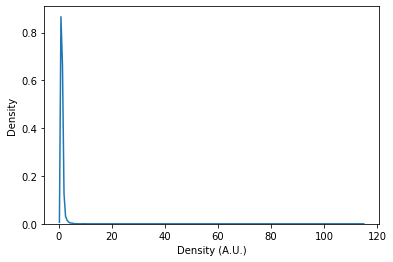

In [11]:
from itertools import chain
h = list(chain.from_iterable([test.amp1_avg.tolist(), test.amp2_avg.tolist()]))
sns.kdeplot(h)
plt.xlabel('Average non-redundant c_AMPs per species per sample')
plt.xlabel('Density (A.U.)')

<AxesSubplot:xlabel='prop', ylabel='logp'>

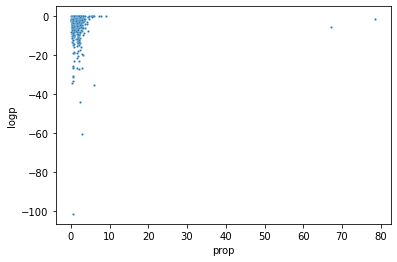

In [12]:
import numpy as np
test['prop'] = test.amp1_avg / test.amp2_avg
test['logp'] = np.log10(test.p_adj)

sns.scatterplot(data=test,
           x='prop',
           y='logp',
           s=5)

In [13]:
print('Human-associated environments')
test[(test.env1.str.contains('human')) & (test.env2.str.contains('human'))]

Human-associated environments


,species,env1,n1_samples,amp1_avg,amp1_std,env2,n2_samples,amp2_avg,amp2_std,p_value,p_adj,prop,logp
536,Acinetobacter schindleri,human gut,67,1.014925,0.122169,human skin,60,1.000000,0.000000,0.352087,1.0,1.014925,0.0
545,Acinetobacter sp003611455,human gut,10,1.000000,0.000000,human skin,10,1.000000,0.000000,1.000000,1.0,1.000000,0.0
551,Acinetobacter tandoii,human gut,21,1.000000,0.000000,human skin,29,1.000000,0.000000,1.000000,1.0,1.000000,0.0
556,Actinomyces dentalis,human gut,11,1.090909,0.301511,human mouth,240,1.812500,1.019809,0.009217,1.0,0.601881,0.0
557,Actinomyces graevenitzii,human gut,43,1.139535,0.350605,human mouth,194,1.278351,0.571196,0.194245,1.0,0.891410,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11130,Veillonella sp900556785,human mouth,29,1.034483,0.185695,human respiratory tract,10,1.100000,0.316228,0.448785,1.0,0.940439,0.0
11131,Veillonella tobetsuensis,human gut,92,1.152174,0.443135,human mouth,74,1.135135,0.381932,0.872343,1.0,1.015010,0.0
11132,Veillonella tobetsuensis,human gut,92,1.152174,0.443135,human respiratory tract,18,1.055556,0.235702,0.370589,1.0,1.091533,0.0
11133,Veillonella tobetsuensis,human mouth,74,1.135135,0.381932,human respiratory tract,18,1.055556,0.235702,0.422114,1.0,1.075391,0.0


In [14]:
print('Human-associated environments and significant')
test[(test.env1.str.contains('human')) & (test.env2.str.contains('human')) & (test.p_adj < 0.05)]

Human-associated environments and significant


,species,env1,n1_samples,amp1_avg,amp1_std,env2,n2_samples,amp2_avg,amp2_std,p_value,p_adj,prop,logp
1611,C941 sp004557565,human gut,298,2.013423,1.260573,human mouth,33,1.000000,0.000000,6.159207e-08,6.738365e-04,2.013423,-3.171445
8800,Staphylococcus hominis,human gut,467,2.580300,1.033494,human skin,156,1.717949,0.785308,8.405931e-20,9.423048e-16,1.501966,-15.025809
